In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
from IPython import display
from IPython.display import clear_output
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.python import metrics
from tensorflow.python.training.tracking.util import Checkpoint
from matplotlib.cbook import CallbackRegistry
from google.colab import drive
import os

In [2]:
drive.mount('/content/gdrive', force_remount=True,timeout_ms=300000)

Mounted at /content/gdrive


In [3]:
#path root
path='/content/gdrive/MyDrive/Colab Notebooks'

#output data path
outpath=path+'/clean spectrograms'

#path of the checkpoints
ckpath=path+'/checkpoinsts'

In [4]:
!nvidia-smi -L

GPU 0: A100-SXM4-40GB (UUID: GPU-375623ac-91da-074e-85eb-ba040c181a89)


# Dataset directory creation

In [5]:
#Spectrogram Directory

lot=[]

for i in range(0,24):
  r=path+'/Data lote '+str(i+1)
  lot.append(r)

In [6]:
def lslot(lot):
  lslot=[]
  for i in lot:
    ls= !ls -1 "{i}"
    lslot.append(ls)
    print(len(lslot))
  return lslot

In [7]:
lst=lslot(lot)

1
2
3
4
5


KeyboardInterrupt: ignored

In [ ]:
#Batch sorting function
def organizer_data(imglist,lot,ls):
  for i in imglist:
    data_name=str(i)
    data_name=data_name.split('_')
    target=data_name[0]+'_'+data_name[2]
    ls.append([str(i),lot,target])

In [ ]:
imgurin=[]
for i0, i1 in zip(lot, lst):
  organizer_data(i1,i0,imgurin)

In [ ]:
imgurin[0]

In [ ]:
imgurin=np.array(imgurin)

In [ ]:
imgurin.shape

In [ ]:
#numpy save
#np.savez_compressed(path+'/ls', d=imgurin)

# Dataset directory load

In [5]:
loaded = np.load(path+'/ls.npz')

In [6]:
imgurin_save=loaded['d']

In [7]:
imgurin_save[0]

array(['116_525_c1.png',
       '/content/gdrive/MyDrive/Colab Notebooks/Data lote 1',
       '116_c1.png'], dtype='<U52')

In [8]:
imgurin_save.shape

(600000, 3)

#Image preprocessing

In [27]:
#number of data
n=len(imgurin_save)
train_n=round(n*0.85)

#Randomized Listing
randurls= np.copy(imgurin_save)

np.random.seed(9) #to have the same aletoriedad
np.random.shuffle(randurls)

#Partition: train and test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(tr_urls.shape, ts_urls.shape, imgurin_save.shape)

(510000, 3) (90000, 3) (600000, 3)


In [28]:
#image size

img_width = 256
img_height = 256

#image rescaling

def resize(resize_img, heigth, width):

  resize_img=tf.image.resize(resize_img, [heigth,width])

  return resize_img

#normalizes from a range -1 - 1

def normalize(norma_img):

  norma_img=(norma_img/127.5)-1

  return norma_img

#upload the images input -target

def load_image(filename):

  img_input = tf.cast(tf.image.decode_png(tf.io.read_file(filename[1]+'/'+filename[0])),tf.float32)[...,:3]
  img_tar = tf.cast(tf.image.decode_png(tf.io.read_file(outpath+'/'+filename[2])),tf.float32)[...,:3]

  img_input = resize(img_input, img_height, img_width)
  img_tar = resize(img_tar, img_height, img_width)
  
  img_input = normalize(img_input)
  img_tar = normalize(img_tar)

  return img_input, img_tar

def load_image_data(filename):
  return load_image(filename)

In [ ]:
plt.imshow(((load_image_data(tr_urls[5])[0])+1)/2)

In [ ]:
plt.imshow(((load_image_data(ts_urls[0])[1])+1)/2)

# Data set function creation

In [29]:
#dataset creation

train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_image_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_image_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

#Neural network creation

In [12]:
def downsample(filters, apply_batchnorm=True):
  result= Sequential()

  initializer=tf.random_normal_initializer(0,0.02)

  #capa convolucional
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  #capa de BarchNorm.
  if apply_batchnorm:
    result.add(BatchNormalization())
  #capa de activación.
  result.add(LeakyReLU())

  return result

In [13]:
def upsample(filters, apply_dropout=False):
  result= Sequential()

  initializer=tf.random_normal_initializer(0,0.02)

  #capa convolucional
  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))
  #capa de BarchNorm.
  result.add(BatchNormalization())

  if apply_dropout:
    #Capa de Dropout.
    result.add(Dropout(0.5))
  #capa de activación.
  result.add(ReLU())

  return result

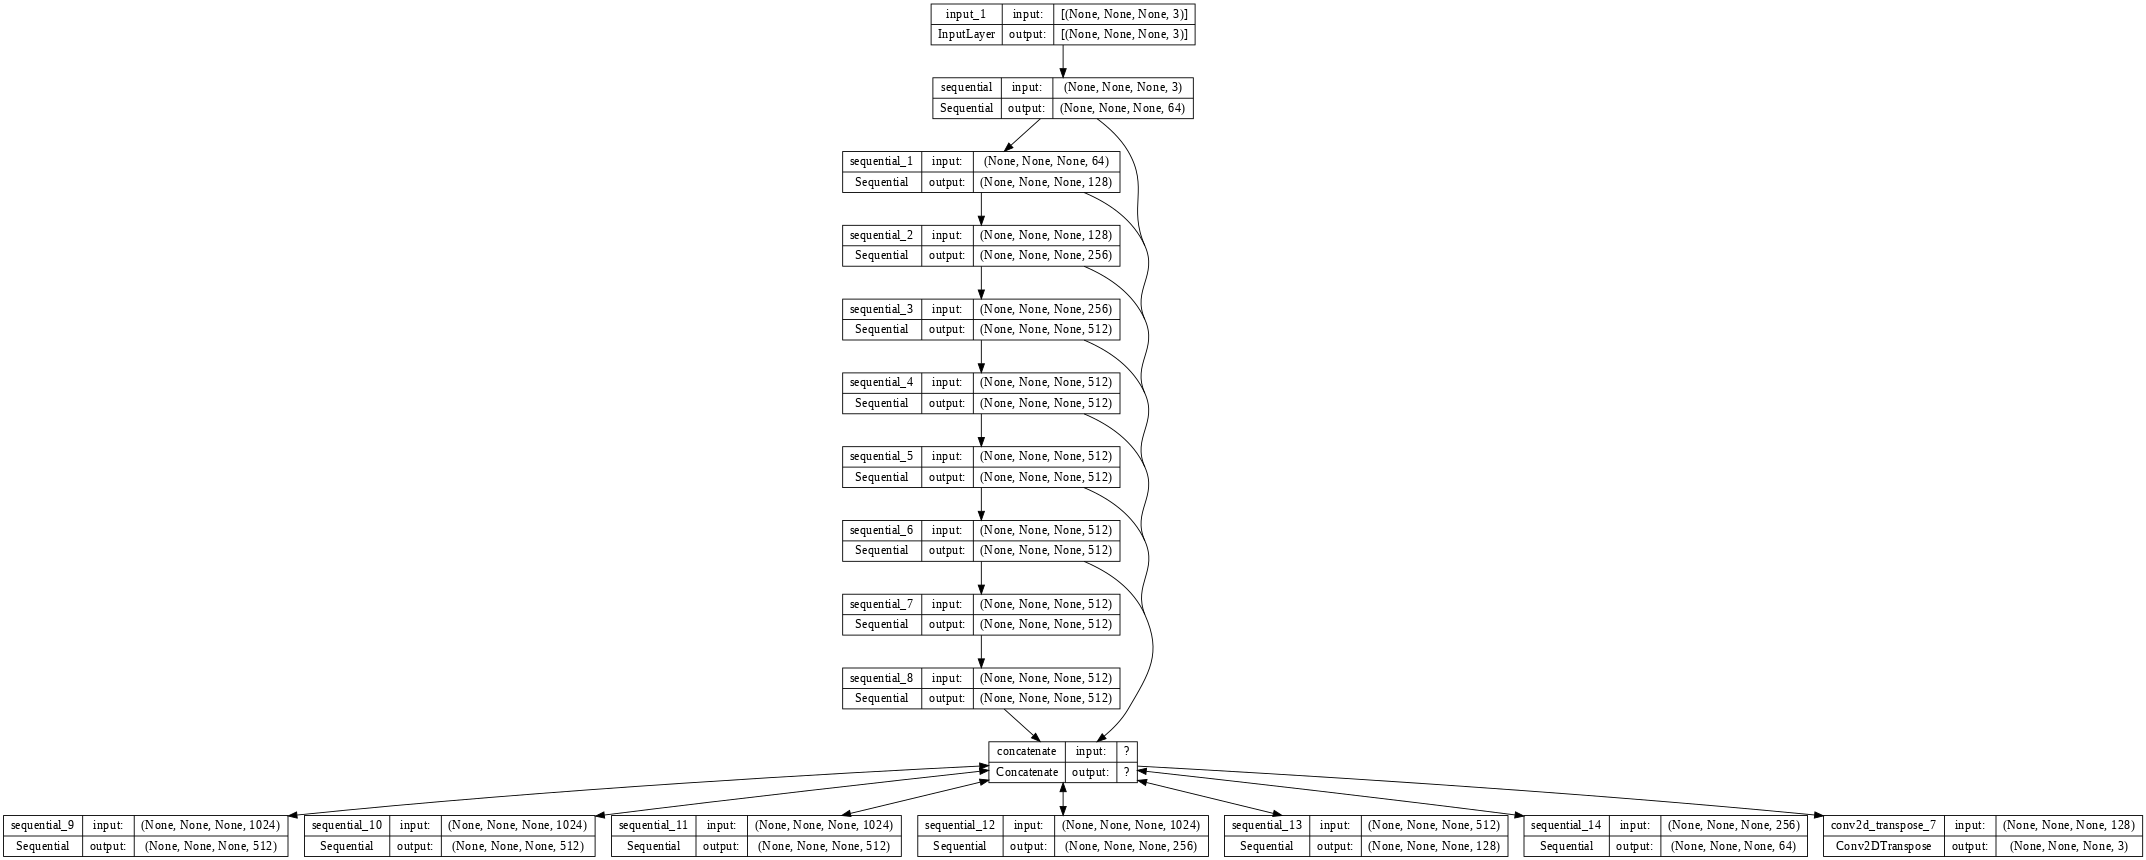

In [14]:
def Generator():
  
  inputs = tf.keras.layers.Input(shape=[None,None,3])

  down_stack= [
               downsample(64, apply_batchnorm=False), #(bs,128,128,64)
               downsample(128),                       #(bs,64,64,128)
               downsample(256),                       #(bs,32,32,256)
               downsample(512),                       #(bs,16,16,512)
               downsample(512),                       #(bs,8,8,512)
               downsample(512),                       #(bs,4,4,512)
               downsample(512),                       #(bs,2,2,512)
               downsample(512),                       #(bs,1,1,512)
  ]

  up_stack= [
               upsample(512, apply_dropout=True),   #(bs,2,2,1024)
               upsample(512, apply_dropout=True),   #(bs,4,4,1024)
               upsample(512, apply_dropout=True),   #(bs,8,8,1024)
               upsample(512),                       #(bs,16,16,1024)
               upsample(256),                       #(bs,32,32,512)
               upsample(128),                       #(bs,64,64,256)
               upsample(64),                        #(bs,128,128,128)
  ]

  initializer = tf.random_normal_initializer(0,0.02)
  last=Conv2DTranspose(filters=3,
                       kernel_size=4,
                       strides=2,
                       padding="same",
                       kernel_initializer=initializer,
                       activation="tanh")
  x=inputs
  s= []

  concat = Concatenate()

  for down in down_stack:
    x=down(x)
    s.append(x)

  s=reversed(s[:-1])
  
  for up, sk in zip(up_stack,s):

    x=up(x)
    x=concat([x,sk])

  last = last(x)

  return Model(inputs=inputs, outputs=last)

generator=Generator()

generator.compile(metrics='AUC')

tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

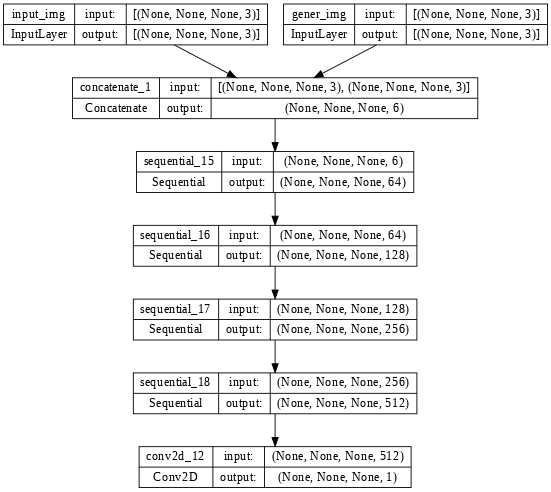

In [15]:
def Discriminator():
  ini=Input(shape=[None,None,3], name="input_img")
  gen=Input(shape=[None,None,3], name="gener_img")

  con=concatenate([ini,gen])

  initializer=tf.random_normal_initializer(0,0.02)

  down1 = downsample(64, apply_batchnorm=False)(con) # (batch_size, 128, 128, 64)
  down2 = downsample(128)(down1) # (batch_size, 64, 64, 128)
  down3 = downsample(256)(down2) # (batch_size, 32, 32, 256)
  down4 = downsample(512)(down3) # (batch_size, 30, 30, 512)

  last=tf.keras.layers.Conv2D(filters=1,
                              kernel_size=4,
                              strides=1,
                              kernel_initializer=initializer,
                              padding="same")(down4)
  return tf.keras.Model(inputs=[ini,gen], outputs=last)

discriminator=Discriminator()

discriminator.compile(metrics='AUC')

tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [16]:
loss_object= tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(disc_real_output, disc_generated_output):
  
  # Diferencia entre los true puede ser real y el detectado puede el discriminador/Difference between true can be real and detected by the discriminator
  real_loss=loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Diferencia entre los false por ser generado y el detectado por el discriminador/Difference between the false to be generated and the one detected by the discriminator.
  generated_loss=loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)

  total_disc_loss=real_loss+generated_loss

  return total_disc_loss

In [34]:
LAMBDA=150

def generator_loss(disc_generated_output,gen_output,target):
  gan_loss=loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  #mean absolute error - adversary
  l1_loss=tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss=gan_loss+(LAMBDA*l1_loss)
  return total_gen_loss, l1_loss, gan_loss

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [20]:
checkpoint_prefix= os.path.join(ckpath,"ckpt")
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               generator=generator,
                               discriminator=discriminator)

In [21]:
def generate_images(model, test_input, tar, save_filename=False,display_imgs=True):

  prediction=model(test_input,training=True)

  plt.figure(figsize=(10,10))
  display_list=[test_input[0],tar[0],prediction[0]]
  title=['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1,3,i+1)
      plt.title(title[i])
      # geting the pixel values betwen [0,1] to plot it.
      plt.imshow(display_list[i]*0.5+0.5)
      plt.axis('off')
    plt.show()

  if save_filename:
    prediction=resize(prediction, 1090, 1900)
    tf.keras.preprocessing.image.save_img(path+'/output/'+save_filename+'.png',prediction[0,...])

In [22]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir+'/fit/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

#Training and Test function

In [23]:
@tf.function()
def train_step(input_image, target, step):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image=generator(input_image,training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr) 

    gen_loss_total, gen_gan_loss, gen_l1_loss= generator_loss(output_gen_discr,output_image, target)

    #gradient gradient calculation

    generator_grands=gen_tape.gradient(gen_loss_total, generator.trainable_variables)

    discriminator_grads=discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    #gradient adjustment

    generator_optimizer.apply_gradients(zip(generator_grands,generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

  #error saving 

  with summary_writer.as_default():
    tf.summary.scalar('gen_loss', gen_loss_total, step=step//102000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//102000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//102000)
    tf.summary.scalar('discr_loss', discr_loss, step=step//102000)

In [24]:
@tf.function()
def test_step(input_image, target, step):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image=generator(input_image,training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr) 

    gen_loss_total, gen_gan_loss, gen_l1_loss = generator_loss(output_gen_discr,output_image, target)

  with summary_writer.as_default():
    tf.summary.scalar('test_gen_loss', gen_loss_total, step=step//3000)
    tf.summary.scalar('test_gen_gan_loss', gen_gan_loss, step=step//3000)
    tf.summary.scalar('test_gen_l1_loss', gen_l1_loss, step=step//3000)
    tf.summary.scalar('test_discr_loss', discr_loss, step=step//3000)

In [25]:
def train(dataset ,steps, epoch):
  a=0
  while a<epoch:
    for step,image in dataset.take(steps).enumerate().repeat():
      print('steps= '+str(step.numpy())+'/',steps,' epoch=',a)
      train_step(image[0],image[1],step)
      clear_output(wait=True)
      if (step + 1) % 102000 == 0:  
        checkpoint.save(file_prefix=checkpoint_prefix)
        lst=lslot(lot)
      if (step + 1) % 1000 == 0:
        lst=lslot(lot)    
    a+=1

In [26]:
def test(dataset ,steps):
  for step,image in dataset.take(steps).enumerate():
    print('steps= '+str(step.numpy())+'/',steps)
    test_step(image[0],image[1],step)
    clear_output(wait=True)

#Training and testing

In [ ]:
train(train_dataset , len(tr_urls), 1)

In [ ]:
test(test_dataset , len(ts_urls)) 

In [ ]:
!tensorboard dev upload --logdir  ./logs --name "test" --description "v0.01"

rest checkpoint

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(ckpath))

#Error tests

In [31]:
for steps, img in test_dataset.take(20).enumerate():
  #test..
  gen_output = generator(img[0], training=True)
  disc_out = discriminator([img[1], gen_output], training=True)
  #plot results
  plt.figure(figsize=(15,15))
  display_list=[img[0],img[1],gen_output,disc_out,]
  title=['Input Image', 'Clear Espc..', 'Predicted Image','discrinator']
  for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(title[i])
    # geting the pixel values betwen [0,1] to plot it.
    if i <= 2:
      plt.imshow(display_list[i][0, ...]*0.5+0.5)
      plt.axis('off')
    else:
      plt.imshow(display_list[i][0, ..., -1],vmin=-20, vmax=20, cmap='RdBu_r')
      #plt.colorbar()

Output hidden; open in https://colab.research.google.com to view.

In [35]:
rmse=[]
for steps, img in test_dataset.take(len(ts_urls)).enumerate():
  #test..
  gen_output = generator(img[0], training=True)
  mse = (np.square(img[1] - gen_output)).mean()
  print('MSE=',mse,'/dato ',steps.numpy())
  rmse.append(mse)

Se han truncado las últimas 5000 líneas del flujo de salida.
MSE= 0.02319318 /dato  85000
MSE= 0.089243405 /dato  85001
MSE= 0.090438545 /dato  85002
MSE= 0.029308071 /dato  85003
MSE= 0.031259 /dato  85004
MSE= 0.04077641 /dato  85005
MSE= 0.040531013 /dato  85006
MSE= 0.10124931 /dato  85007
MSE= 0.036690462 /dato  85008
MSE= 0.028189959 /dato  85009
MSE= 0.026208526 /dato  85010
MSE= 0.0419599 /dato  85011
MSE= 0.11067716 /dato  85012
MSE= 0.04212978 /dato  85013
MSE= 0.022431806 /dato  85014
MSE= 0.027872985 /dato  85015
MSE= 0.019267347 /dato  85016
MSE= 0.036892053 /dato  85017
MSE= 0.033782076 /dato  85018
MSE= 0.037848923 /dato  85019
MSE= 0.03379562 /dato  85020
MSE= 0.04457974 /dato  85021
MSE= 0.025060752 /dato  85022
MSE= 0.033813007 /dato  85023
MSE= 0.032427207 /dato  85024
MSE= 0.032642398 /dato  85025
MSE= 0.04082868 /dato  85026
MSE= 0.044164017 /dato  85027
MSE= 0.03185365 /dato  85028
MSE= 0.097601004 /dato  85029
MSE= 0.032018907 /dato  85030
MSE= 0.02445691 /dato  

#Save and load model .h5

In [ ]:
generator.save('/content/gdrive/MyDrive/Colab Notebooks/save_model/generator.h5')
discriminator.save('/content/gdrive/MyDrive/Colab Notebooks/save_model/discriminator.h5')

In [32]:
generator_load=tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/save_model/generator.h5')
generator_load.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3136        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131584      ['sequential[0][0]']             
                                128)                                                          

In [33]:
discriminator_load=tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/save_model/discriminator.h5')
discriminator_load.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 gener_img (InputLayer)         [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 concatenate_1 (Concatenate)    (None, None, None,   0           ['input_img[0][0]',              
                                6)                                'gener_img[0][0]']        

In [ ]:
#tests of the saved model
for img in test_dataset.take(2):
  #test..
  gen_output = generator_load(img[0], training=True)
  disc_out = discriminator_load([img[1], gen_output], training=True)
  #plot results
  plt.figure(figsize=(15,15))
  display_list=[img[0],img[1],gen_output,disc_out,]
  title=['Input Image', 'Clear Espc..', 'Predicted Image','discrinator']
  for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(title[i])
    # geting the pixel values betwen [0,1] to plot it.
    if i <= 2:
      plt.imshow(display_list[i][0, ...]*0.5+0.5)
      plt.axis('off')
    else:
      plt.imshow(display_list[i][0, ..., -1]*0.5+0.5,vmin=-15, vmax=15, cmap='RdBu_r')
      #plt.colorbar()